# TorchQuantum Qubit Rotation Tutorial

> Note: This tutorial was adapted from Pennylane's [Basic tutorial: qubit rotation](https://pennylane.ai/qml/demos/tutorial_qubit_rotation) by Josh Izaac.

To see how TorchQuantum allows the easy construction and optimization of quantum functions, let's consider the simple case of qubit rotation.

The task at hand is to optimize two rotation gates in order to flip a single qubit from state |0⟩ to state |1⟩.



## The quantum circuit

In the qubit rotation example, we wish to implement the following quantum circuit:

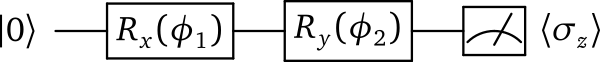

Breaking this down step-by-step, we first start with a qubit in the ground state $|0⟩ = [1\ 0]^T$, and rotate it around the x-axis by applying the gate

$\begin{split}R_x(\phi_1) = e^{-i \phi_1 \sigma_x /2} =
\begin{bmatrix}
\cos \frac{\phi_1}{2} & -i \sin \frac{\phi_1}{2}
\\
-i \sin \frac{\phi_1}{2} & \cos \frac{\phi_1}{2}
\end{bmatrix},
\end{split}$

and then around the y-axis via the gate

$\begin{split}R_y(\phi_2) = e^{-i \phi_2 \sigma_y/2} =
\begin{bmatrix} \cos \frac{\phi_2}{2} & - \sin \frac{\phi_2}{2}
\\
\sin \frac{\phi_2}{2} & \cos \frac{\phi_2}{2}
\end{bmatrix}.\end{split}$

After these operations the qubit is now in the state

$| \psi \rangle = R_y(\phi_2) R_x(\phi_1) | 0 \rangle.$

Finally, we measure the expectation value $⟨ψ∣σ_z∣ψ⟩$ of the Pauli-Z operator

Using the above to calculate the exact expectation value, we find that

$\begin{split}\sigma_z =
\begin{bmatrix} 1 & 0
\\
0 & -1
\end{bmatrix}.\end{split}$

Depending on the circuit parameters $ϕ_1$ and $ϕ_2$, the output expectation lies between 1 (if $|ψ⟩ = |0⟩) and -1 (if |ψ⟩ = |1⟩).

$\langle \psi \mid \sigma_z \mid \psi \rangle
      = \langle 0 \mid R_x(\phi_1)^\dagger R_y(\phi_2)^\dagger \sigma_z R_y(\phi_2) R_x(\phi_1) \mid 0 \rangle
      = \cos(\phi_1)\cos(\phi_2).$

Let's see how we can easily implement and optimize this circuit using TorchQuantum.



## Importing TorchQuantum

The first thing we need to do is install and import TorchQuantum. To utilize all of TorchQuantum's features, install it from source.

In [1]:
!git clone https://github.com/mit-han-lab/torchquantum.git
!cd torchquantum && pip install --editable .

Cloning into 'torchquantum'...
remote: Enumerating objects: 13551, done.
remote: Counting objects: 100% (1822/1822), done.
remote: Compressing objects: 100% (758/758), done.
remote: Total 13551 (delta 1085), reused 1640 (delta 980), pack-reused 11729
Receiving objects: 100% (13551/13551), 104.07 MiB | 21.17 MiB/s, done.
Resolving deltas: 100% (7442/7442), done.
Obtaining file:///content/torchquantum
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 23.6 MB/s eta 

> **Note: To be able to install TorchQuantum on Colab, you must restart your runtime before continuing!**

After installing from source (and restarting if using Colab!), you can import TorchQuantum.

In [1]:
import torchquantum as tq

## Creating a device

Before we can construct our quantum node, we need to initialize a device.

> **Definition**
>
> Any computational object that can apply quantum operations and return a measurement value is called a quantum **device**.

> *Devices are loaded in PennyLane via the class [QuantumDevice()](https://github.com/mit-han-lab/torchquantum/blob/main/torchquantum/devices.py#L13)*


For this tutorial, we are using the qubit model, so let's initialize the 'default' device provided by TorchQuantum.

In [4]:
qdev = tq.QuantumDevice(
    n_wires=1, device_name="default", bsz=1, device="cuda", record_op=True
)

For all devices, [QuantumDevice()](https://github.com/mit-han-lab/torchquantum/blob/main/torchquantum/devices.py#L13) accepts the following arguments:

* n_wires: number of qubits to initialize the device with
* device_name: name of the quantum device to be loaded
* bsz: batch size of the quantum state
* device: which classical computing device to use, 'cpu' or 'cuda' (similar to the device option in PyTorch)
* record_op: whether to record the operations on the quantum device and then they can be used to construct a static computation graph

Here, as we only require a single qubit for this example, we set wires=1.

## Constructing the Circuit

Now that we have initialized our device, we can begin to construct the circuit. In TorchQuantum, there are multiple ways to construct a circuit, and we can explore a few of them.

In [5]:
# specify parameters
params = [0.54, 0.12]

# create circuit
qdev.rx(params=params[0], wires=0)
qdev.ry(params=params[1], wires=0)

This method calls the gates directly from the QuantumDevice. For the rotations, we can specify which wire it belongs to (zero-indexed) and a parameter theta for the amount of rotation. However, the rotation gates also have other parameters.

* wires: which qibits the gate is applied to
* theta: the amount of rotation
* n_wires: number of qubits the gate is applied to
* static: whether use static mode computation
* parent_graph: Parent QuantumGraph of current operation
* inverse: whether inverse the gate
* comp_method: option to use 'bmm' or 'einsum' method to perform matrix vector multiplication

To get the following expected value, we can use two different functions from torchquantum's measurement module.

In [6]:
from torchquantum.measurement import expval_joint_analytical, expval_joint_sampling

* `expval_joint_analytical` will compute the expectation value of a joint observable in analytical way, assuming the statevector is available. This can only be run on a classical simulator, not real quantum hardware.

* `expval_joint_analytical` will compute the expectation value of a joint observable from sampling the measurement bistring. This can be run on both a classical simulation and real quantum hardware. Since this is sampling the measurements, it requires a parameters for the number of shots, `n_shots`.



In [7]:
exp_a = expval_joint_analytical(qdev, "Z")
exp_s = expval_joint_sampling(qdev, "Z", n_shots=1024)

print(exp_a, exp_s)

tensor([0.8515]) tensor([0.8184])


The two numbers are about the same, and if we increase the number of shots for the joint sampling, its expected value should approach the same value as the analytical.

## Calculating quantum gradients

From the expected values output, notice that the analytical expected value has an automatically-calculated gradient which can be used when constructing quantum machine learning models. This is because TorchQuantum automatically calculates the gradients. Let's find the gradient of each individual gate.

To do so, we can create the circuit slightly differently, saving each operation as a variable then adding it to the circuit. We can then once again get the expected value with `expval_joint_analytical`.

In [8]:
qdev = tq.QuantumDevice(n_wires=1)

op1 = tq.RX(has_params=True, trainable=True, init_params=0.54)
op1(qdev, wires=0)

op2 = tq.RY(has_params=True, trainable=True, init_params=0.12)
op2(qdev, wires=0)


expval = expval_joint_analytical(qdev, "Z")

We can then call `.backward()` on the expected value, just like in PyTorch. Afterwards, we can see the gradient of each operation under the `params` option.

In [9]:
expval[0].backward()

# calculate the gradients for each operation!
print(op1.params.grad, op2.params.grad)

tensor([[-0.5104]]) tensor([[-0.1027]])


## Optimization

Next, let's make use of PyTorch's optimizers to optimize the two circuit parameters $\phi_1$ and $\phi_2$ such that the qubit, originally in state |0⟩, is rotated to be in state |1⟩. This is equivalent to measuring a Pauli-Z expectation value of -1, since the state |1⟩ is an eigenvector of the Pauli-Z matrix with eigenvalue λ=−1.

To construct this circuit, we can use a class similar to a PyTorch module! We can begin by importing torch.

In [38]:
import torch

We can next create the class extending the PyTorch module and add our gates in a similar fashion as the previous steps.

In [39]:
import torchquantum as tq
import torchquantum.functional as tqf


class OptimizationModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rx0 = tq.RX(has_params=True, trainable=True, init_params=0.011)
        self.ry0 = tq.RY(has_params=True, trainable=True, init_params=0.012)

    def forward(self):
        # create a quantum device to run the gates
        qdev = tq.QuantumDevice(n_wires=1)

        # add some trainable gates (need to instantiate ahead of time)
        self.rx0(qdev, wires=0)
        self.ry0(qdev, wires=0)

        return expval_joint_analytical(qdev, "Z")

To optimize the rotation, we need to define a cost function. By minimizing the cost function, the optimizer will determine the values of the circuit parameters that produce the desired outcome.

In this case, our desired outcome is a Pauli-Z expectation value of −1. Since we know that the Pauli-Z expectation is bound between [−1, 1], we can define our cost directly as the output of the circuit.

Similar to PyTorch, we can create a train function to compute the gradients of the loss function and have the optimizer perform an optimization step.

In [53]:
def train(model, device, optimizer):
    targets = 0

    outputs = model()
    loss = outputs
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

Finally, we can run the model. We can import PyTorch's gradient descent module and use it to optimize our model.

In [54]:
def main():
    seed = 0
    torch.manual_seed(seed)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model = OptimizationModel()
    n_epochs = 200
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    for epoch in range(1, n_epochs + 1):
        # train
        loss = train(model, device, optimizer)
        output = (model.rx0.params[0].item(), model.ry0.params[0].item())
        print(f"Epoch {epoch}: {output}")

        if epoch % 10 == 0:
            print(f"Loss after step {epoch}: {loss}")

Finally, we can call the main function and run the entire sequence!

In [55]:
main()

Epoch 1: (0.012099898420274258, 0.013199898414313793)
Epoch 2: (0.013309753499925137, 0.014519752934575081)
Epoch 3: (0.014640549197793007, 0.015971548855304718)
Epoch 4: (0.01610436476767063, 0.017568465322256088)
Epoch 5: (0.01771448366343975, 0.01932499371469021)
Epoch 6: (0.019485509023070335, 0.02125706896185875)
Epoch 7: (0.021433496847748756, 0.023382212966680527)
Epoch 8: (0.023576095700263977, 0.02571968361735344)
Epoch 9: (0.025932706892490387, 0.028290653601288795)
Epoch 10: (0.028524650260806084, 0.03111839108169079)
Loss after step 10: 0.9992638230323792
Epoch 11: (0.031375348567962646, 0.03422846272587776)
Epoch 12: (0.0345105305314064, 0.03764895722270012)
Epoch 13: (0.037958454340696335, 0.041410721838474274)
Epoch 14: (0.04175013676285744, 0.04554762691259384)
Epoch 15: (0.04591960832476616, 0.050096847116947174)
Epoch 16: (0.05050419643521309, 0.055099159479141235)
Epoch 17: (0.05554480850696564, 0.06059926748275757)
Epoch 18: (0.06108624115586281, 0.06664614379405975

We can see that the optimization converges after approximately 160 steps.

Substituting this into the theoretical result $⟨ψ∣σ_z∣ψ⟩ = \cos ϕ_1 \cos ϕ_2$, we can verify that this is indeed one possible value of the circuit parameters that produces $⟨ψ∣σ_z∣ψ⟩ = −1$, resulting in the qubit being rotated to the state |1⟩.

